In [1]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
import pandas as pd

filename = './data/biz_log.csv'
df = pd.read_csv( filename, sep=', ')
df.to_json('./data/biz_log.ndjson', orient='records', force_ascii=False, lines=True)
df.to_csv('./data/biz_log.json.csv', sep=',', index=False)

df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_24096\1493279974.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv( filename, sep=', ')


,proc_date,proc_hour,proc_time,emp_cd,emp_nm,user_id,user_ip,dept_cd,dept_nm,org_cd,...,assu_org_cd,assu_org_nm,assu_hq_cd,assu_hq_nm,audit_no,grade,status,log_seq,sys_cd,log_agency_cd
0,20171101,1030.0,36.0,20150068.0,황혜련,20150068.0,10.1.72.55,DB5,약제기준부,DB0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41596.0,AB01,HI
1,20171101,1030.0,35.0,20150068.0,황혜련,20150068.0,10.1.72.55,DB5,약제기준부,DB0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41595.0,AB01,HI
2,20171101,1026.0,38.0,20150068.0,황혜련,20150068.0,10.1.72.55,DB5,약제기준부,DB0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41594.0,AB01,HI
3,20171101,1026.0,36.0,20150068.0,황혜련,20150068.0,10.1.72.55,DB5,약제기준부,DB0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41593.0,AB01,HI
4,20171101,1425.0,21.0,20162405.0,박아결,20162405.0,10.100.4.66,CH9,정보화지원부,CH0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41592.0,AB01,HI


In [3]:
df.shape

(7786, 82)

In [4]:
df.isna().sum()

proc_date           0
proc_hour           1
proc_time           1
emp_cd              1
emp_nm              1
                 ... 
grade            7786
status           7786
log_seq             1
sys_cd              1
log_agency_cd       1
Length: 82, dtype: int64

In [5]:
remove_columns = [key for value, key in zip(df.isna().sum(), df.columns) if value == df.shape[0]]

print( remove_columns )

df.drop(columns=remove_columns, inplace=True)
print(df.isna().sum())


['hq_nm', 'posit_gu', 'acc_org_cd', 'acc_org_nm', 'acc_hq_cd', 'acc_hq_nm', 'bran_cd', 'bran_nm', 'nh_dept_cd', 'nh_dept_nm', 'cd_org_cd', 'cd_org_nm', 'car_cd', 'site_cd', 'member_div', 'ssn_name', 'sear_cont', 'cert_num', 'sear_log24', 'esta_sym', 'firm_nm', 'assu_ssn', 'assu_nm', 'contact_condition', 'psnl_inf_qry_hed_colnm', 'psnl_inf_cnts', 'output_pgm_id', 'inq_db', 'patient_cd', 'patient_nm', 'bloodno', 'result', 'scrn_id', 'scrn_nm', 'vcls', 'ssn_org_cd', 'ssn_org_nm', 'ssn_hq_cd', 'ssn_hq_nm', 'juri_out', 'firm_cd', 'firm_cd_nm', 'firm_hq_cd', 'firm_hq_nm', 'assu_org_cd', 'assu_org_nm', 'assu_hq_cd', 'assu_hq_nm', 'audit_no', 'grade', 'status']
proc_date            0
proc_hour            1
proc_time            1
emp_cd               1
emp_nm               1
user_id              1
user_ip              1
dept_cd              1
dept_nm              1
org_cd               1
org_nm               1
hq_cd                1
join_ssn             1
sear_val          5917
inq_seq         

In [6]:
name_columns = list(filter(lambda x: 'nm' in x, df.columns))
# 'prg_nm' ??
print(df[name_columns].isna().sum())
df.drop(columns=name_columns, inplace=True)
print(df.isna().sum())


emp_nm         1
dept_nm        1
org_nm         1
ykiho_nm    3100
busi_nm     7498
prg_nm       289
dtype: int64
proc_date            0
proc_hour            1
proc_time            1
emp_cd               1
user_id              1
user_ip              1
dept_cd              1
org_cd               1
hq_cd                1
join_ssn             1
sear_val          5917
inq_seq              1
per_inf_cd        5917
inq_reason        7341
ykiho_cd          1412
recv_no           5980
recv_yyyy         5980
busi_cd           7498
busi_dtl_contn    7674
button_cd            1
prg_id             289
req_url           7498
log_seq              1
sys_cd               1
log_agency_cd        1
dtype: int64


In [7]:
from opensearchpy import OpenSearch

client = OpenSearch(
    hosts = [{"host": "default-opensearch-node1-0c190-1595032-15144b153298.kr-gov.lb.naverncp.com", "port": 9200}],
    http_auth = ("admin", "admin"),
    use_ssl = True,
    verify_certs = False,
    ssl_assert_hostname = False,
    ssl_show_warn = False,
)
client.info()

{'name': 'opensearch-node1',
 'cluster_name': 'opensearch-cluster',
 'cluster_uuid': 'BAa1QZeQQ0O06tlxAX0P8g',
 'version': {'distribution': 'opensearch',
  'number': '2.6.0',
  'build_type': 'tar',
  'build_hash': '7203a5af21a8a009aece1474446b437a3c674db6',
  'build_date': '2023-02-24T18:57:04.388618985Z',
  'build_snapshot': False,
  'lucene_version': '9.5.0',
  'minimum_wire_compatibility_version': '7.10.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'The OpenSearch Project: https://opensearch.org/'}

In [9]:
import json 

properties = dict()
for column in df.columns:
    properties.update( { column : { 'type' : 'text' } } )

properties

body = {
  "mappings": {
    "properties": properties
  }
}

print(json.dumps( body, indent=2))
response = client.indices.create("biz_logs", body=body)

{
  "mappings": {
    "properties": {
      "proc_date": {
        "type": "text"
      },
      "proc_hour": {
        "type": "text"
      },
      "proc_time": {
        "type": "text"
      },
      "emp_cd": {
        "type": "text"
      },
      "user_id": {
        "type": "text"
      },
      "user_ip": {
        "type": "text"
      },
      "dept_cd": {
        "type": "text"
      },
      "org_cd": {
        "type": "text"
      },
      "hq_cd": {
        "type": "text"
      },
      "join_ssn": {
        "type": "text"
      },
      "sear_val": {
        "type": "text"
      },
      "inq_seq": {
        "type": "text"
      },
      "per_inf_cd": {
        "type": "text"
      },
      "inq_reason": {
        "type": "text"
      },
      "ykiho_cd": {
        "type": "text"
      },
      "recv_no": {
        "type": "text"
      },
      "recv_yyyy": {
        "type": "text"
      },
      "busi_cd": {
        "type": "text"
      },
      "busi_dtl_contn": {
     

In [15]:
from opensearchpy.helpers import bulk

bulk_data = []

for i, row in df.iterrows():
    body = dict()
    for key, value in row.items():
        body.update( { key : value } )

        bulk_data.append({
            "_index": "biz_logs",
            "_id": i,
            "_source": body
        })

     
    # print( body )

    bulk(client, bulk_data)


BulkIndexError: ('25 document(s) failed to index.', [{'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}, {'index': {'_index': 'biz_logs', '_id': '0', 'status': 400, 'error': {'type': 'mapper_parsing_exception', 'reason': 'failed to parse', 'caused_by': {'type': 'json_parse_exception', 'reason': 'Non-standard token \'NaN\': enable `JsonReadFeature.ALLOW_NON_NUMERIC_NUMBERS` to allow\n at [Source: (byte[])"{"proc_date":"20171101","proc_hour":1030.0,"proc_time":36.0,"emp_cd":20150068.0,"user_id":20150068.0,"user_ip":"10.1.72.55","dept_cd":"DB5","org_cd":"DB0","hq_cd":"00","join_ssn":"dd90baa12f3f6d4bef1a506c856ee5f9","sear_val":NaN,"inq_seq":6626256.0,"per_inf_cd":NaN,"inq_reason":NaN,"ykiho_cd":NaN,"recv_no":NaN,"recv_yyyy":NaN,"busi_cd":2.0,"busi_dtl_contn":"1498","button_cd":"R","prg_id":NaN,"req_url":"http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do","log_seq":41596.0,"sys_cd":"AB01""[truncated 22 bytes]; line: 1, column: 229]'}}, 'data': {'proc_date': '20171101', 'proc_hour': 1030.0, 'proc_time': 36.0, 'emp_cd': 20150068.0, 'user_id': 20150068.0, 'user_ip': '10.1.72.55', 'dept_cd': 'DB5', 'org_cd': 'DB0', 'hq_cd': '00', 'join_ssn': 'dd90baa12f3f6d4bef1a506c856ee5f9', 'sear_val': nan, 'inq_seq': 6626256.0, 'per_inf_cd': nan, 'inq_reason': nan, 'ykiho_cd': nan, 'recv_no': nan, 'recv_yyyy': nan, 'busi_cd': 2.0, 'busi_dtl_contn': '1498', 'button_cd': 'R', 'prg_id': nan, 'req_url': 'http://biznet.hira.or.kr/ga/gac/selectDramtStdExamSearch.do', 'log_seq': 41596.0, 'sys_cd': 'AB01', 'log_agency_cd': 'HI'}}}])

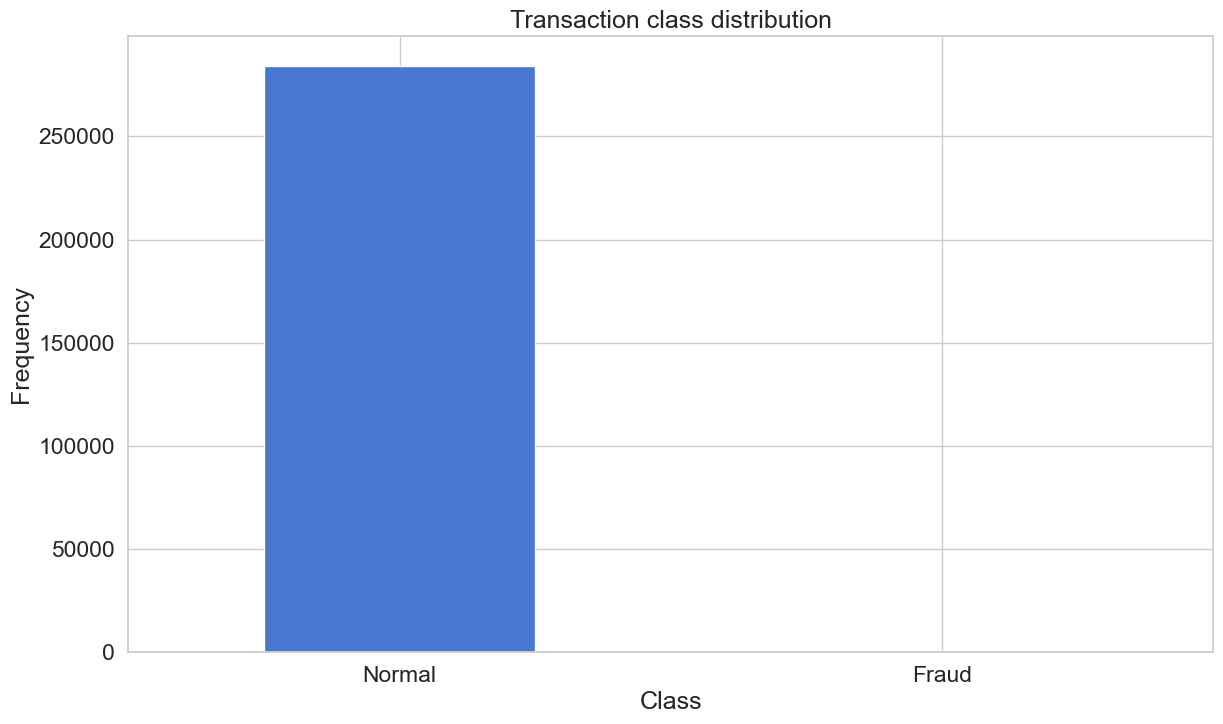

In [16]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [17]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [18]:
normal.shape

(284315, 31)

In [19]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [20]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

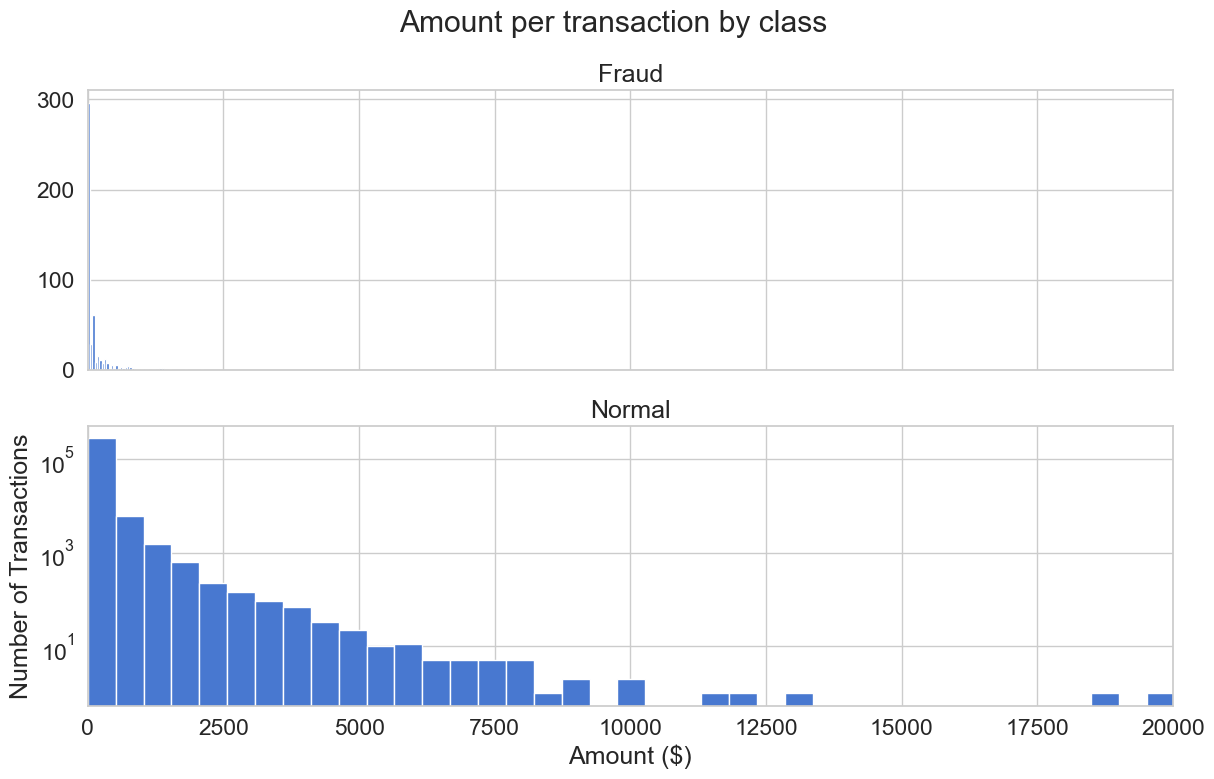

In [21]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

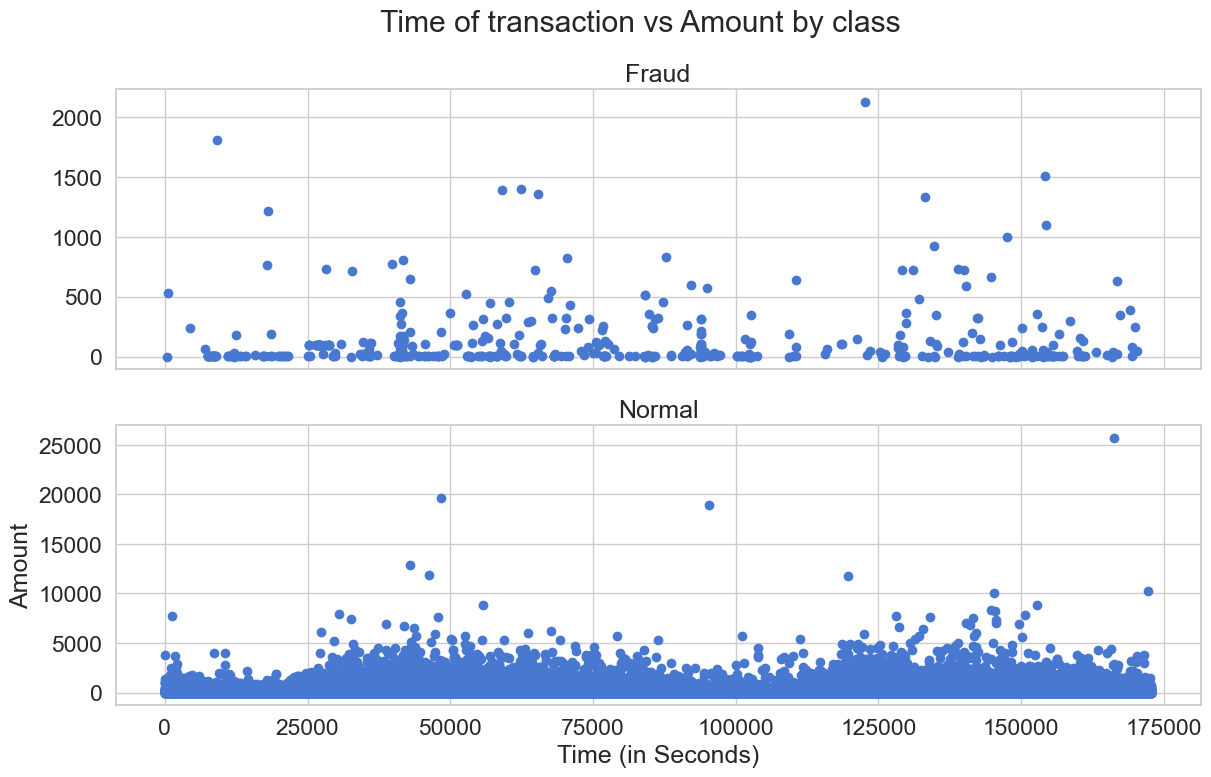

In [22]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [24]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [25]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(227451, 29)

In [26]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [27]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.7996 - accuracy: 0.5942 - val_loss: 0.7727 - val_accuracy: 0.6555
Epoch 2/100
7108/7108 [==============================] - 13s 2ms/step - loss: 0.7307 - accuracy: 0.6769 - val_loss: 0.7541 - val_accuracy: 0.6866
Epoch 3/100
7108/7108 [==============================] - 13s 2ms/step - loss: 0.7188 - accuracy: 0.6939 - val_loss: 0.7477 - val_accuracy: 0.7006
Epoch 4/100
7108/7108 [==============================] - 13s 2ms/step - loss: 0.7136 - accuracy: 0.7024 - val_loss: 0.7458 - val_accuracy: 0.6988
Epoch 5/100
7108/7108 [==============================] - 13s 2ms/step - loss: 0.7102 - accuracy: 0.7085 - val_loss: 0.7407 - val_accuracy: 0.7107
Epoch 6/100
7108/7108 [==============================] - 13s 2ms/step - loss: 0.7063 - accuracy: 0.7145 - val_loss: 0.7395 - val_accuracy: 0.7094
Epoch 7/100
7108/7108 [==============================] - 13s 2ms/step - loss: 0.7035 - accuracy: 0.7178 - val_loss: 0.7356 -

In [12]:
file = './internal_ip_status'

with open( file=file, mode='r' ) as fr:
    plain = fr.read()

# list(map(lambda x: x.split()[-1] , plain.split('\n')))

for line in plain.split('\n'):
    x = line.split()[-1]
    if x.startswith('192'):
        print( x )

192.168.1.2
192.168.1.6
192.168.1.8
192.168.1.9
192.168.1.10
192.168.1.12
192.168.1.15
192.168.1.16
192.168.1.18
192.168.1.19
192.168.1.20
192.168.1.25
192.168.1.30
192.168.1.37
192.168.1.38


IndexError: list index out of range

In [ ]:
text = '''DBConnectionPoolManager.java
LogFileRecvServer.java
EzFullScanEngineExecutor.java
EzFullScanEngineExecutor.java
EzFileUtil.java
EzMiPlatformDecompressor.java
ProcPropertiesBack.java
DataParserController.java
DataParserController.java
DataParserController.java
DataParserController.java
DataParserController.java
DataParserController.java
DataParserController.java
LogFileRecvServer.java
LogFileRecvServer.java
NhFireDecrypto.java
NhFireDecrypto.java
PrivDownloadLogCollector.java
PrivDownloadLogCollector.java
PrivDownloadLogCollector.java
PatternParser.java
PatternParser.java
PatternParser.java
DBCrypWrapper.java
DBCrypWrapper.java
DBCrypWrapper.java
DBCrypWrapper.java
DBCrypWrapper.java
RecoveryMain.java
RecoveryMain.java
RecoveryMain.java
RecoveryMain.java
RecoveryMain.java
RecoveryMain2.java
RecoveryMain2.java
RecoveryMain2.java
RecoveryMain2.java
RecoveryMain2.java
RecoveryMain2.java
APPEONDataConverter.java
EzLogReader.java
EzLogReader.java
EzLogReader.java
FileMover2.java
GZipUtil.java
CommandClient.java
DBConnectionPoolManager.java
EzFileUtil.java
EzFileUtil.java
EzMiPlatformDecompressor.java
StringUtils.java
UserActionFinder.java
UserActionFinder.java
UserActionFinder.java
DataParserController.java
DataParserController.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
RegexController.java
NHparseLogService.java
CommandClient.java
DBConnectionPoolManager.java
FileParser.java
FileParserDao.java
FileParserDao.java
FileParserDao.java
FileParserDao.java
FileParserDao.java
FileParserDao.java
FileParserDao.java
EzFileUtil.java
EzFileUtil.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
ProcPropertiesBack.java
StringUtils.java
StringUtils.java
UserActionFinder.java
UserActionFinder.java
UserActionFinder.java
UserActionFinder.java
DataParserController.java
DataParserController.java
DataParserController.java
DataParserController.java
DataParserController.java
LogFileRecvServer.java
LogFileRecvServer.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
NhFireDecrypto.java
NhFireDecrypto.java
NhFireDecrypto.java
PrivDownloadLogCollector.java
PrivDownloadLogCollector.java
RegexController.java
PatternParser.java
PatternParser.java
PatternParser.java
PatternParser.java
SSNChecker.java
DBCrypWrapper.java
DaoImpl.java
DaoImpl.java
DaoImpl.java
DaoImpl.java
DaoImpl.java
DaoImpl.java
DaoImpl.java
RecoveryMain.java
RecoveryMain.java
RecoveryMain.java
RecoveryMain2.java
RecoveryMain2.java
RecoveryMain2.java
RecoveryMain2.java
APPEONDataConverter.java
APPEONDataConverter.java
APPEONDataConverter.java
APPEONDataConverter.java
EzHash.java
EzLogReader.java
EzLogReader.java
EzLogReader.java
EzLogReader.java
EzLogReader.java
GZipUtil.java
NHLogReaderLauncher.java
NHLogReaderLauncher.java
NHLogReaderLauncher.java
NHLogReaderLauncher.java
NHLogReaderLauncher.java
NHDao.java
NHparseLogService.java
NHparseLogService.java
RedcrossDaoImpl.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
EzMiPlatformDecompressor.java
StringUtils.java
StringUtils.java
StringUtils.java
StringUtils.java
DataParserController.java
MultifileReader.java
MultifileReader.java
MultifileReader.java
PrivDownloadLogCollector.java
Main.java
RecoveryMain.java
RecoveryMain.java
RecoveryMain.java
RecoveryMain.java
RecoveryMain2.java
RecoveryMain2.java
RecoveryMain2.java
RecoveryMain2.java
RecoveryMain2.java
RecoveryMain2.java
APPEONDataConverter.java
APPEONDataConverter.java
APPEONDataConverter.java
EzLogReader.java
EzLogReader.java
EzLogReader.java
NHDao.java
DBConnectionPoolManager.java
FileParser.java
EzFileUtil.java
ProcPropertiesBack.java
LogFileRecvServer.java
MultifileReader.java
PrivDownloadLogCollector.java
RecoveryMain.java
RecoveryMain2.java
APPEONDataConverter.java
EzLogReader.java
NHLogReaderLauncher.java
NHLogReaderLauncher.java
NHDao.java
NHDao.java
NHDao.java'''

In [15]:
print(*sorted(list(set(text.split('\n')))), sep='\n')

APPEONDataConverter.java
AgentStatusCheckerMain.java
CommandClient.java
CommonConst.java
DBConnectionPoolManager.java
DBCrypWrapper.java
DaoImpl.java
DataParserController.java
EzFileUtil.java
EzFullScanEngineExecutor.java
EzHash.java
EzLogReader.java
EzMiPlatformDecompressor.java
EzStringUtil.java
FileMover2.java
FileParser.java
FileParserDao.java
FileParserLauncher.java
GZipUtil.java
LogFileRecvServer.java
Main.java
MultifileReader.java
NHDao.java
NHFireCustom.java
NHLogReaderLauncher.java
NHparseLogService.java
NhFireDecrypto.java
PatternParser.java
PrivDownloadLogCollector.java
ProcPropertiesBack.java
RParserApplication.java
RecoveryMain.java
RecoveryMain2.java
RedcrossDaoImpl.java
RegexController.java
SSNChecker.java
SiteCustom_518.java
StringUtils.java
UserActionFinder.java
